# Compairison of vectorizers

This notebook presents the preliminary test task for the transformer models. I estimate the quaity of the language modelling by the classification task. 

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
! pip install transformers

     |████████████████████████████████| 2.3MB 26.9MB/s 
     |████████████████████████████████| 901kB 29.9MB/s 
     |████████████████████████████████| 3.3MB 53.0MB/s 


In [3]:
import transformers
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
import random
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

## Data

I introduce the dataset consisting of 3 semantic fields: *hiding*, *seeking* and *changing*. *Hiding* and *seeking* include two major internal oppositions (hide/conceal, seek/find). I expect the models to differenciate between the fields better than between the internal oppositions. 

In [4]:
df = pd.read_csv('/content/drive/MyDrive/frames_billion.csv',  delimiter='\t')

In [5]:
df.drop_duplicates('sentence').groupby(['field']).count()

,id,sentence,form_subj,lemma_subj,form_verb,lemma_verb,form_obj,lemma_obj
field,,,,,,,,
искать,22077,22077,22077,22077,22077,22077,22077,22077
менять,19970,19970,19970,19970,19970,19970,19970,19970
находить,46639,46639,46639,46639,46639,46639,46639,46639
прятать,3149,3149,3149,3149,3149,3149,3149,3149
скрывать,4275,4275,4275,4275,4275,4275,4275,4275


In [6]:
df.drop_duplicates('sentence', inplace=True)

Let's check which lexemes are included in each semantic field.

In [7]:
df[df['field']=='искать']['lemma_verb'].unique()

array(['искать', 'обыскать', 'обыскивать', 'разыскивать', 'снискать',
       'подыскивать', 'взыскивать', 'очискать', 'отыскивать', 'разыскать',
       'дыскать', 'подыскать', 'вычискать', 'поискать', 'чискать',
       'взыскать', 'расчискать', 'прочискать', 'изыскивать', 'зачискать',
       'начискать', 'пискать', 'отыскать', 'опрыскивать', 'истискать',
       'тискать', 'обчискать', 'потискать', 'изыскать', 'тыскать',
       'плакатискать', 'сыскивать', 'ходилискать', 'яискать',
       'впрыскивать', 'сыскать', ',искать', 'отчискать', 'цыскать',
       'распрыскивать', 'предвосхискать', 'убежискать', 'вспрыскивать',
       ',очискать', 'рыскивать', 'усискать', 'мытискать', 'розыскивать',
       ',поискать', 'выискать', 'прзвискать', '-поискать',
       'пристанискать', 'фискать', 'дочискать', 'прыскивать', 'ыскать',
       'рискать', 'искал-искать', 'запискать', 'захискать', 'зривискать',
       'нискать', 'обиталискать', 'особискать', 'вискать', '-дыскать',
       '...искать', 'приб

In [ ]:
df[df['field']=='менять']['lemma_verb'].unique()

array(['сменять', 'заменять', 'изменять', 'менять', 'поменять', 'вменять',
       'подменять', 'разменять', 'обменять', 'видоизменять', 'обременять',
       'дменять', 'переменять', 'выменять', 'променять', '&gt;&gt;менять',
       'true"/ooменять', 'неотменять', 'инеприменять', 'невменять',
       'имитирует-заменять', 'орденаприменять', 'сможетизменять',
       ',поменять', ',менять', 'онамменять', '.менять', 'осеменять',
       'семенять', 'людяхподменять', 'воспламенять', 'за-менять',
       ')менять', 'взаимозаменять', 'при-менять', 'доменять',
       'засеменять', '-менять', 'окаменять', 'а)сменять', '.поменять',
       ',изменять', 'наменять', 'пр-роменять', 'замечаю-что-мне-изменять',
       ',...поменять', 'улицыпоменять', '-заменять', 'обре-менять',
       'знаменять', 'видо-изменять'], dtype=object)

In [ ]:
df[df['field']=='прятать']['lemma_verb'].unique()

array(['прятать', 'спрятывать', 'спрятать', 'припрятывать', 'припрятать',
       'попрятывать', 'попрятать', 'запрятывать', 'упрятать',
       'перепрятать', 'упрятывать', 'запрятать', 'прятывать',
       'перепрятывать', 'по-прятывать', '/прятать'], dtype=object)

In [ ]:
df[df['field']=='скрывать']['lemma_verb'].unique()

array(['скрывать', 'скрыть'], dtype=object)

In [ ]:
df[df['field']=='находить']['lemma_verb'].unique()

array(['находить', 'ненаходить', 'иненаходить', '&quot;находить',
       'понаходить', '/ooнаходить', '8.находить', 'тумананаходить',
       'инаходить', 'true"/ooнаходить', '.находить', 'знаходить',
       '-находить', ',-находить', '...находить', ',находить',
       'преднаходить', ',он,-находить', '.....находить', 'винаходить',
       'вднаходить', 'н-находить', '\\*находить'], dtype=object)

As we can see the initial peprocessing of Taiga corpus is quite poor, so we have to clean it manually. 

In [7]:
change = ['менять',
                  'изменять',
                  'заменять',
                  'взаимозаменять',
                  'выменять',
                  'заменять',
                  'наменять',
                  'обменять',
                  'переменять',
                  'подменять',
                  'поменять',
                  'променять',
                  'разменять',
                  'сменять']
search = ['выискать',
              'наискать',
              'обыскать',
              'обыскивать',
              'отыскать',
              'отыскивать',
              'подыскать',
              'подыскивать',
              'поискать',
              'разыскать',
              'разыскивать']
find = ['находить']
hide = ['запрятать',
              'запрятывать',
              'перепрятать',
              'перепрятывать',
              'припрятать',
              'припрятывать',
              'прятать',
              'спрятать',
              'упрятать']
conceal = ['скрывать', 'скрыть']
verb_set = change + conceal + hide + find + search
df['clean'] = df.apply(lambda x: x['lemma_verb'] in set(verb_set), axis=1)
df = df.loc[df.clean == True]

In [ ]:
df

,id,sentence,field,form_subj,lemma_subj,form_verb,lemma_verb,form_obj,lemma_obj,clean
0,1,С августа 2009 по март 2011 года он похитил у ...,находить,действия,действие,нашли,находить,подтверждение,подтверждение,True
1,2,Бывший префект Северного административного окр...,менять,который,который,сменил,сменять,его,он,True
2,3,Пуля от M1911 Фото: Ali Baldry 1/2Однако архео...,находить,археологи,археолог,нашли,находить,пулю,пуля,True
3,4,"Табличка считалась утерянной почти 80 лет, и н...",находить,археологи,археолог,нашли,находить,ее,она,True
4,5,Его нашли наземные поисковые группы сотруднико...,находить,группы,группа,нашли,находить,его,он,True
...,...,...,...,...,...,...,...,...,...,...
106825,106826,"Он нашел вероятного, хотя и проблематичного, п...",находить,он,он,нашел,находить,вероятного,вероятный,True
106826,106827,А русские нашли к нему какой-то подход.,находить,русские,русский,нашли,находить,подход,подход,True
106828,106829,Через пять минут я нашел редакцию по адресу на...,находить,я,я,нашел,находить,редакцию,редакция,True
106829,106830,И как вы только эту психбольницу отыскали - Ты...,искать,вы,вы,отыскали,отыскивать,психбольницу,психбольница,True


In [8]:
df["field"].replace({'менять' : 'menjatʹ', 'искать' : 'iskatʹ', 'находить' : 'naxoditʹ', 'прятать' : 'prjatatʹ', 'скрывать' : 'skryvatʹ'}, inplace=True)

In [27]:
df.groupby(['field']).count()

,id,sentence,form_subj,lemma_subj,form_verb,lemma_verb,form_obj,lemma_obj,clean
field,,,,,,,,,
iskatʹ,3504,3504,3504,3504,3504,3504,3504,3504,3504
menjatʹ,19525,19525,19525,19525,19525,19525,19525,19525,19525
naxoditʹ,46565,46565,46565,46565,46565,46565,46565,46565,46565
prjatatʹ,2941,2941,2941,2941,2941,2941,2941,2941,2941
skryvatʹ,4275,4275,4275,4275,4275,4275,4275,4275,4275


In [9]:
random.seed(42)
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, random_state=11)

In [ ]:
df_train.to_csv('train.csv')
df_test.to_csv('test.csv')

Since I carry out multi-class classification with uneven number of examples for each class, I am going to report micro f-score as a metric of quality. 

## TF-IDF

In [ ]:
vec = TfidfVectorizer(ngram_range=(1, 4))
bow = vec.fit_transform(df_train['sentence'])
clf = LogisticRegression()

In [ ]:
bow_test = vec.transform(df_test['sentence'])
clf.fit(bow, df_train['field'])
pred = clf.predict(bow_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print(classification_report(pred, df_test['field']))

              precision    recall  f1-score   support

      iskatʹ       0.60      1.00      0.75       546
     menjatʹ       0.95      0.98      0.96      4752
    naxoditʹ       1.00      0.94      0.97     12383
    prjatatʹ       0.79      0.99      0.88       560
    skryvatʹ       0.91      0.98      0.94       962

    accuracy                           0.96     19203
   macro avg       0.85      0.98      0.90     19203
weighted avg       0.97      0.96      0.96     19203



In [ ]:
print(precision_recall_fscore_support(pred, df_test['field'], average='micro'))

(0.9552674061344582, 0.9552674061344582, 0.9552674061344582, None)


## BERT CLS

In [ ]:
import torch
import transformers
from transformers import AutoModel, AutoTokenizer

# https://stackoverflow.com/questions/59619760/multilingual-bert-sentence-vector-captures-language-used-more-than-meaning-wor

bert_name="bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(bert_name)
model = AutoModel.from_pretrained(bert_name).to(device)

def BERT_CLS(df, model, tokenizer):
    embs = []
    tags = []
    for sentence, tag in tqdm(zip(df['sentence'], df['field']), total = df.shape[0]):
        embedding = tokenizer.encode(sentence, add_special_tokens=True)
        if len(embedding) <= 512:
            tags.append(tag)
            embs.append(np.squeeze(model(torch.tensor([embedding]).to(device))[1].cpu().detach().numpy()))
    return embs, tags

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
emb_train, tag_train = BERT_CLS(df_train, model, tokenizer)
emb_test, tag_test = BERT_CLS(df_train, model, tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (618 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
clf = LogisticRegression()

In [ ]:
clf = LogisticRegression()
clf.fit(emb_train, tag_train)
pred = clf.predict(emb_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print(classification_report(pred, tag_test))

              precision    recall  f1-score   support

      iskatʹ       0.18      0.63      0.28       734
     menjatʹ       0.75      0.77      0.76     14126
    naxoditʹ       0.92      0.80      0.85     40139
    prjatatʹ       0.25      0.64      0.36       892
    skryvatʹ       0.32      0.63      0.43      1672

    accuracy                           0.78     57563
   macro avg       0.48      0.69      0.54     57563
weighted avg       0.84      0.78      0.80     57563



In [ ]:
print(precision_recall_fscore_support(pred, tag_test, average='micro'))

(0.7822559630318087, 0.7822559630318087, 0.7822559630318087, None)


## BERT MASK

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM, BertConfig

config = BertConfig.from_pretrained("bert-base-multilingual-cased", output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertForMaskedLM.from_pretrained("bert-base-multilingual-cased", config=config).to(device)

def BERT_MASK(masked, verbs, model, tokenizer):
    embs = []
    tags = []
    for line, tag in tqdm(zip(masked, verbs), total=len(masked)):

        input = tokenizer.encode(line, return_tensors="pt").to(device)
        mask_token_index = torch.where(input == tokenizer.mask_token_id)
        
        try: 
            token_logits = model(input, return_dict=True)["hidden_states"]
            mask_token_logits = token_logits[-1].squeeze()[mask_token_index, :][0]
            embs.append(mask_token_logits.cpu().detach().numpy())
            tags.append(tag)
        except Exception as e:
            print(line)
            print(e)
    return embs, tags

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_masked = []
for i, row in df_train.iterrows():
    train_masked.append(row['sentence'].lower().replace(row['form_verb'], '[MASK]', 1))

In [ ]:
test_masked = []
for i, row in df_test.iterrows():
    test_masked.append(row['sentence'].lower().replace(row['form_verb'], '[MASK]', 1))

In [ ]:
emb_train, tag_train = BERT_MASK(train_masked, df_train['field'], model, tokenizer)
emb_test, tag_test = BERT_MASK(test_masked, df_test['field'], model, tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (611 > 512). Running this sequence through the model will result in indexing errors


когда-то возили его туда и в памяти осталось много людей,больших домов и зелени,а брат там учился,и мальчик этим очень гордился перед единственным на ферме соседским мальчиком на год младшим его.сейчас растопленное солнце,бросающее в уныние взрослых,ничуть не сказывалось на его энергии и настроении.он со свойственным этому возрасту непоседливостью пошел искать себе занятие.побродив немного он [MASK] кучу использованных или испорченных сроком годности ветеринарных медикаментов.сопя начал открывать и нюхать флаконы и склянки,то разбивая их,то смешивая жидкости;найдя несколько шприцев,положил их в карман и взглянул на дорогу-по ней мчалась машина.машина по-хозяйски раскачивалась на неровной дороге словно упитанный утенок,хлопая расшатавшимися бортами.мальчик стоял и думал,что,если машина будет стоять долго,то можно будет сесть на подножку,а,может,даже на бампер и гладить фары-это редко ему удавалось:он не мог туда запрыгнуть и всегда просил кого-нибудь поднять.дождавшись,когда машина приб

слово некому сказать у федота нету слуха , наступил медведь на ухо и стихов не уважает , лишь "муму" мужик читает бродит федя вокруг дома , тащит дров из бурелома то починит , то прибьет , то притащит дикий мед вот жена стихотворенье - запасай к зиме варенье вот алиса песенка -- мухоморов лесенка а любовные страстишки -- это милые детишки вмиг алисе надоела , трудоемкая неделя никакой романтики , шей к подушкам бантики жизнь пошла утопия где же философия в сердце вспыхнула гордыня "я вам федя - не рабыня" собрала ему сундук , вмиг забросила на сук и медведь пошел домой , лист хрустит по мостовой дождь опять бежит с небес , хмуро смотрит голый лес в поле иней серебрится , на канары мчится птица журавлиный киль сверкнул , тихий лес опять уснул и решила дама вновь поискать свою любовь в умном заведении , в библиостроении "там всегда полно мозгов - романтичных мужиков пропадает там эйнштейн , по-немецки "я ферштейн" шубку лисонька одела и в науку полетела муж попался просто клад , филин то

In [ ]:
clf = LogisticRegression()
clf.fit(emb_train, tag_train)
pred = clf.predict(emb_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print(classification_report(pred, tag_test))

              precision    recall  f1-score   support

      iskatʹ       0.01      0.47      0.02        19
     menjatʹ       0.45      0.62      0.52      3589
    naxoditʹ       0.91      0.70      0.79     15162
    prjatatʹ       0.06      0.39      0.11       113
    skryvatʹ       0.16      0.53      0.24       305

    accuracy                           0.68     19188
   macro avg       0.32      0.54      0.34     19188
weighted avg       0.80      0.68      0.72     19188



In [ ]:
print(precision_recall_fscore_support(pred, tag_test, average='micro'))

(0.676725036481134, 0.676725036481134, 0.676725036481134, None)


## BERT SVO

Sum of subject, verb and direct object vectors from BERT vocabulary.

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertModel.from_pretrained("bert-base-multilingual-cased").to(device)

def BERT_SVO(df, model, tokenizer):
    vectors = []
    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        input_ids = torch.tensor(tokenizer.encode(row['form_subj'] + ' ' + \
                                                  row['form_verb'] + ' ' + \
                                                  row['form_obj'])).unsqueeze(0).to(device)
        outputs = model(input_ids)
        last_hidden_states = outputs[0]
        vp_vector = np.sum(last_hidden_states[0].cpu().detach().numpy(), axis=0)
        vectors.append(vp_vector)
    return vectors

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_vectors = BERT_SVO(df_train, model, tokenizer)
test_vectors = BERT_SVO(df_test, model, tokenizer)

In [ ]:
clf = LogisticRegression()
clf.fit(train_vectors, df_train['field'])
pred = clf.predict(test_vectors)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print(classification_report(pred, df_test['field']))

              precision    recall  f1-score   support

      iskatʹ       1.00      1.00      1.00       909
     menjatʹ       1.00      1.00      1.00      4904
    naxoditʹ       1.00      1.00      1.00     11660
    prjatatʹ       1.00      1.00      1.00       701
    skryvatʹ       1.00      1.00      1.00      1029

    accuracy                           1.00     19203
   macro avg       1.00      1.00      1.00     19203
weighted avg       1.00      1.00      1.00     19203



In [ ]:
print(precision_recall_fscore_support(pred, df_test['field'], average='micro'))

(0.9992709472478258, 0.9992709472478258, 0.9992709472478258, None)


## BERT SO

Sum of subject and object vectors from BERT vocabulary.

In [ ]:
def BERT_SO(df, model, tokenizer):
    vectors = []
    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        input_ids = torch.tensor(tokenizer.encode(row['form_subj'] + ' ' + \
                                                  row['form_obj'])).unsqueeze(0).to(device)
        outputs = model(input_ids)
        last_hidden_states = outputs[0]
        vp_vector = np.sum(last_hidden_states[0].cpu().detach().numpy(), axis=0)
        vectors.append(vp_vector)
    return vectors

In [ ]:
train_vectors = BERT_SO(df_train, model, tokenizer)
test_vectors = BERT_SO(df_test, model, tokenizer)

In [ ]:
clf = LogisticRegression()
clf.fit(train_vectors, df_train['field'])
pred = clf.predict(test_vectors)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print(classification_report(pred, df_test['field']))

              precision    recall  f1-score   support

      iskatʹ       0.01      0.21      0.01        29
     menjatʹ       0.50      0.65      0.57      3774
    naxoditʹ       0.91      0.71      0.80     14907
    prjatatʹ       0.11      0.52      0.18       145
    skryvatʹ       0.15      0.46      0.23       348

    accuracy                           0.69     19203
   macro avg       0.34      0.51      0.36     19203
weighted avg       0.81      0.69      0.74     19203



In [ ]:
print(precision_recall_fscore_support(pred, df_test['field'], average='micro'))

(0.6915586106337551, 0.6915586106337551, 0.6915586106337551, None)


## LaBSE

In [10]:
! pip install sentence_transformers

     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 1.2MB 42.2MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.1-cp37-none-any.whl size=123338 sha256=b390096d9ba59aab49da8b300f4e5da3e4b7d0edb32bdfe179db576b01f81669
  Stored in directory: /root/.cache/pip/wheels/5e/89/29/45e45adc162b50f97f71801e8b07947c9cfe2b3ae7dbf37896
Successfully built sentence-transformers


In [11]:
from sentence_transformers import SentenceTransformer

In [ ]:
model = SentenceTransformer('LaBSE')

def LABSE(df, model):
    embs = []
    tags = []
    model.to('cuda')
    for line, tag in tqdm(zip(df['sentence'], df['field']), total=df.shape[0]):
        try: 
            embeddings = model.encode(line)
            embs.append(embeddings)
            tags.append(tag)
        except Exception as e:
            print(line)
            print(e)
    return embs, tags

In [ ]:
emb_train, tag_train = LABSE(df_train, model)
emb_test, tag_test = LABSE(df_test, model)

In [ ]:
clf = LogisticRegression()
clf.fit(emb_train, tag_train)
pred = clf.predict(emb_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print(classification_report(pred, tag_test))

              precision    recall  f1-score   support

      iskatʹ       0.29      0.75      0.42       356
     menjatʹ       0.97      0.97      0.97      4921
    naxoditʹ       0.98      0.93      0.95     12253
    prjatatʹ       0.70      0.85      0.77       579
    skryvatʹ       0.89      0.84      0.87      1094

    accuracy                           0.93     19203
   macro avg       0.77      0.87      0.80     19203
weighted avg       0.95      0.93      0.94     19203



In [ ]:
print(precision_recall_fscore_support(pred, tag_test, average='micro'))

(0.9295943342186117, 0.9295943342186117, 0.9295943342186117, None)


## XLM

In [12]:
from transformers import AutoTokenizer, AutoModel
  
tokenizer = AutoTokenizer.from_pretrained("xlm-mlm-100-1280")

model = AutoModel.from_pretrained("xlm-mlm-100-1280").to('cuda')

Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def XLM(df, model, tokenizer):
    embs = []
    tags = []

    for line, tag in tqdm(zip(df['sentence'], df['field']), total=df.shape[0]):

        try: 
            encoded_input = tokenizer(line, padding=True, truncation=True, max_length=128, return_tensors='pt').to('cuda')

            # Compute token embeddings
            with torch.no_grad():
                model_output = model(**encoded_input)

            # Perform pooling. In this case, mean pooling
            sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
            embs.append(sentence_embeddings[0].cpu().detach().numpy())
            tags.append(tag)
        except Exception as e:
            print(line)
            print(e)
    return embs, tags

In [ ]:
emb_train, tag_train = XLM(df_train, model, tokenizer)
emb_test, tag_test = XLM(df_test, model, tokenizer)

In [ ]:
clf = LogisticRegression()
clf.fit(emb_train, tag_train)
pred = clf.predict(emb_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print(classification_report(pred, tag_test))

              precision    recall  f1-score   support

      iskatʹ       0.89      0.91      0.90       896
     menjatʹ       0.97      0.97      0.97      4890
    naxoditʹ       0.98      0.98      0.98     11711
    prjatatʹ       0.90      0.94      0.92       669
    skryvatʹ       0.94      0.93      0.93      1037

    accuracy                           0.97     19203
   macro avg       0.94      0.95      0.94     19203
weighted avg       0.97      0.97      0.97     19203



In [ ]:
print(precision_recall_fscore_support(pred, tag_test, average='micro'))

(0.9708899651096183, 0.9708899651096183, 0.9708899651096183, None)


## Clusterization with all fields

### XLM

In [14]:
! pip uninstall umap
! pip install umap-learn

     |████████████████████████████████| 81kB 10.0MB/s 
     |████████████████████████████████| 1.2MB 43.1MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=b95af853b172e94a31b5385629fe40aa0c7b1e622d7375871f32c95997ab6065
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=d933b49f094eb12e76d416b667237008d5ad8c307e3fd75bbdb8ca7e733b94c9
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [39]:
tokenizer = AutoTokenizer.from_pretrained("xlm-mlm-100-1280")
model = AutoModel.from_pretrained("xlm-mlm-100-1280").to('cuda')

Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
embeddings_all, tags_all = XLM(df, model, tokenizer)

In [16]:
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap

reducer = umap.UMAP()
Y = reducer.fit_transform(StandardScaler().fit_transform(embeddings_all))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[None, None, None, None, None, None, None, None, None, None]

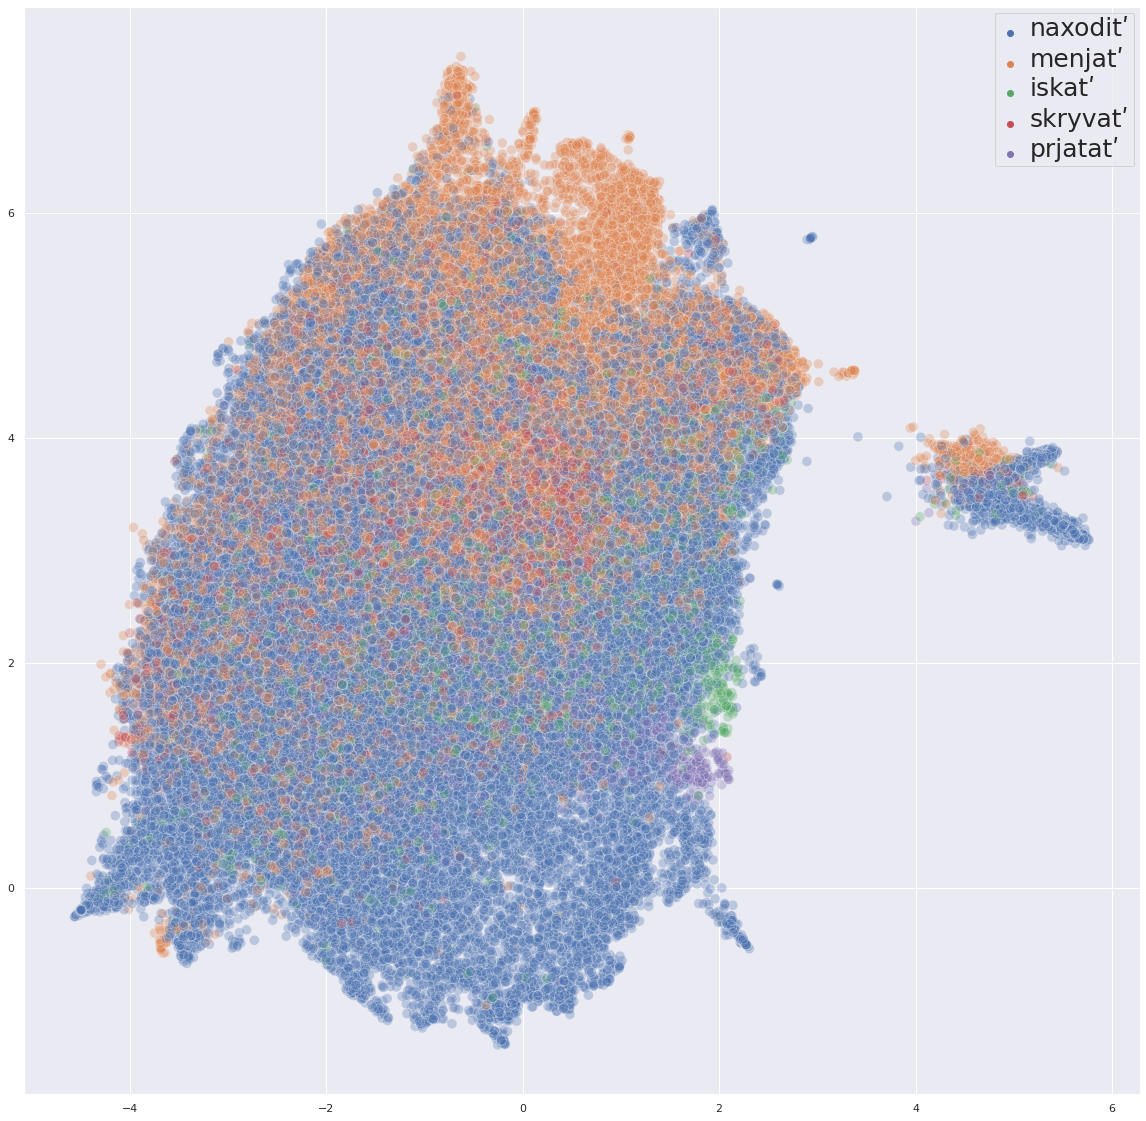

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(20, 20)})
graph = sns.scatterplot(Y[:, 0], Y[:, 1],  s=100, alpha=.3, hue=tags_all)  
plt.setp(graph.get_legend().get_texts(), fontsize='25')

### LaBSE

In [ ]:
model = SentenceTransformer('LaBSE')

In [73]:
embeddings_all, tags_all = LABSE(df, model)

In [74]:
reducer = umap.UMAP()
Y = reducer.fit_transform(StandardScaler().fit_transform(embeddings_all))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[None, None, None, None, None, None, None, None, None, None]

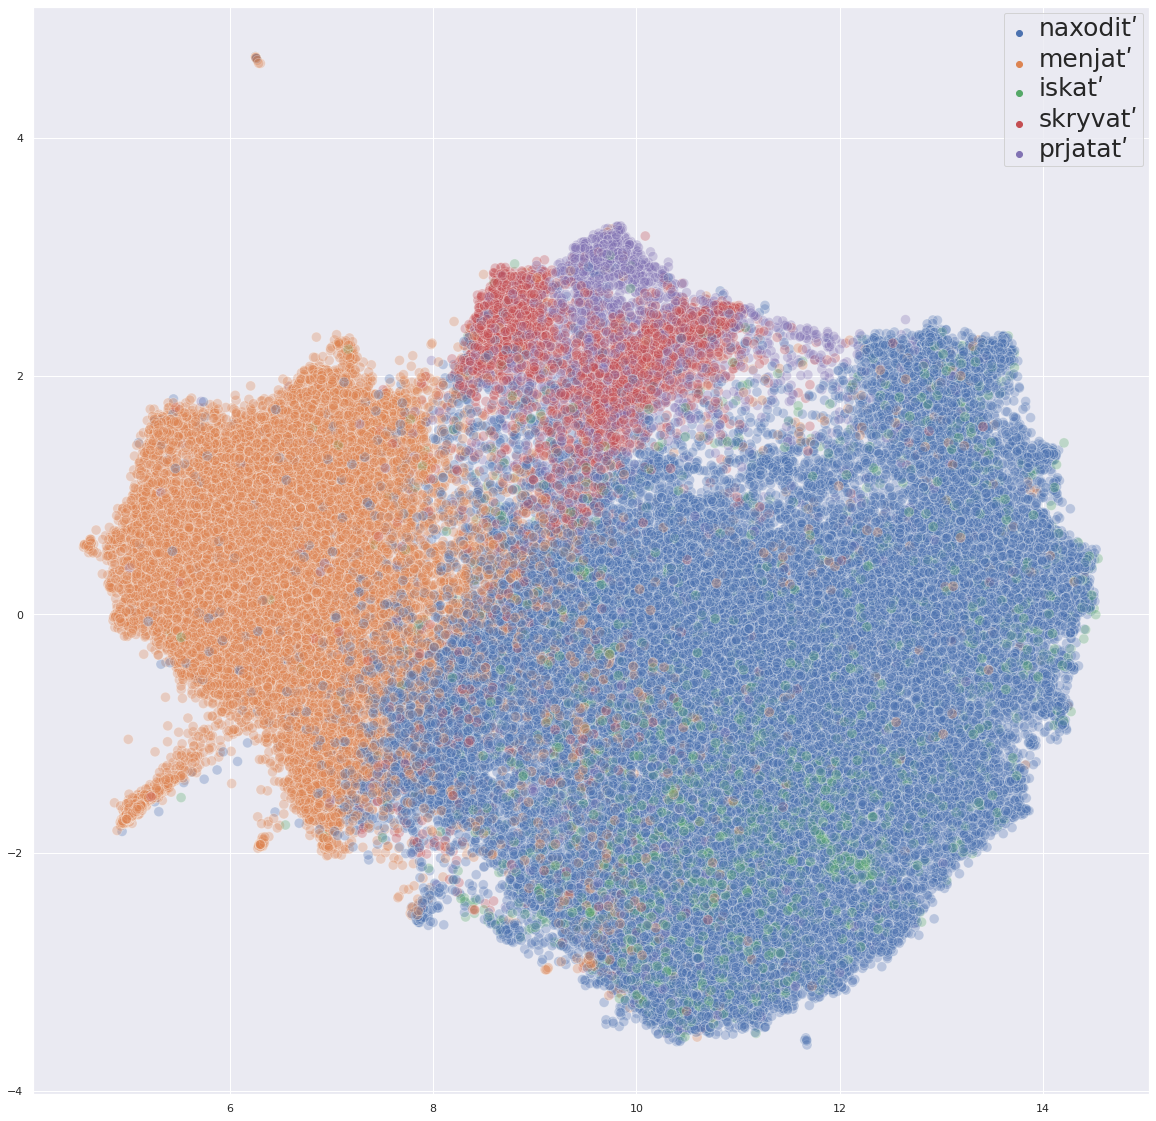

In [75]:
sns.set(rc={'figure.figsize':(20, 20)})
graph = sns.scatterplot(Y[:, 0], Y[:, 1],  s=100, alpha=.3, hue=tags_all) 
plt.setp(graph.get_legend().get_texts(), fontsize='25')